Copyright © 2023 "Bronte" Sihan Li

## Experiment with Network Variations

The next task is to undertake some experimentation with the deep network for the MNIST task. Your goal is to evaluate the effect of changing different aspects of the network. Pick at least three dimensions along which you can change the network architecture and see if you can optimize the network performance and/or training time along those three dimensions. Do your best to automate the process.

You may want to try using the MNIST Fashion data set instead of the digits data set for this step. The fashion data set is a little more challenging, but similar in size, and it provides more room to see the effects of changes in the network.

The number of convolution layers
The size of the convolution filters
The number of convolution filters in a layer
The number of hidden nodes in the Dense layer
The dropout rates of the Dropout layer
Whether to add another dropout layer after the fully connected layer
The size of the pooling layer filters
The number or location of pooling layers
The activation function for each layer
The number of epochs of training
The batch size while training

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

### Develop a Plan

* Train with default config to get baseline results
* Separate our data into training, validation and test sets
* Define search configs for hyper-parameters and set up pipelines
* Search through combinations with Ray Tune
* Evaluate and present the best model configs

In [2]:
# Construct a dictionary of hyper-parameters

batch_size_test = 10000

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
# Define the device to be used for training
# Here we use M1 GPU acceleration
device = torch.device('mps')

In [3]:
# Load the fashion MNIST dataset, split training data into training and test data

from utils.train_test import load_data

train_loader, test_loader, _ = load_data(dataset='fashion_mnist', batch_size_train=32, batch_size_test=batch_size_test)

/var/folders/cx/l3gnx5dn4gs_zc1wtxc7xyf40000gn/T/ipykernel_37331/2149451187.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


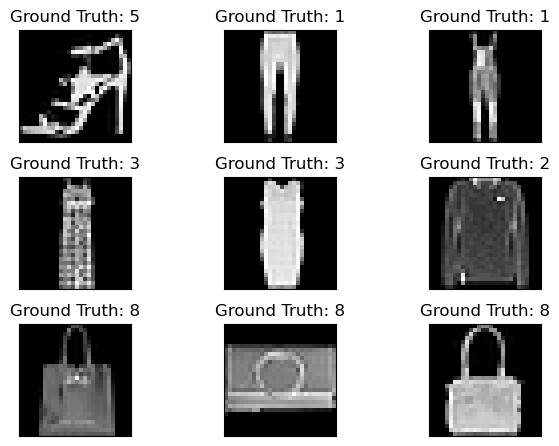

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data.to('cpu')[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig.show()

First, we use the default CNN configuration to train and see what the baseline results are.

In [5]:
from utils.net import Net
from utils.train_test import train, test

# Initialize the neural network and optimizer
net = Net(config='c1')
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.5)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
for param in net.parameters():
    print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([10, 1, 2, 2])
<class 'torch.nn.parameter.Parameter'> torch.Size([10])
<class 'torch.nn.parameter.Parameter'> torch.Size([20, 10, 2, 2])
<class 'torch.nn.parameter.Parameter'> torch.Size([20])
<class 'torch.nn.parameter.UninitializedParameter'> torch.Size([0])
<class 'torch.nn.parameter.UninitializedParameter'> torch.Size([0])
<class 'torch.nn.parameter.Parameter'> torch.Size([50, 320])
<class 'torch.nn.parameter.Parameter'> torch.Size([50])
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 50])
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


In [9]:
train_losses_all = []
train_counter_all = []

test_losses = test(network=net, test_loader=test_loader)
print(len(test_losses))
test_counter = [i*len(train_loader.dataset) for i in range(3 + 1)]
for epoch in range(1, 3 + 1):
  train_losses, train_counter = train(epoch=epoch, train_loader=train_loader, batch_size_train=16,
        network=net, optimizer=optimizer, log_interval=10, save_dir='results/fashion_mnist')
  test_losses += test(network=net, test_loader=test_loader)
  print(len(test_losses))
  train_losses_all += train_losses
  train_counter_all += train_counter


Test set: Avg. loss: 2.3096, Accuracy: 1695/10000 (17%)

1
torch.Size([32, 1, 28, 28])
torch.Size([32, 10]) torch.Size([32])
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.337080
torch.Size([32, 1, 28, 28])
torch.Size([32, 10]) torch.Size([32])
torch.Size([32, 1, 28, 28])
torch.Size([32, 10]) torch.Size([32])
torch.Size([32, 1, 28, 28])
torch.Size([32, 10]) torch.Size([32])
torch.Size([32, 1, 28, 28])
torch.Size([32, 10]) torch.Size([32])
torch.Size([32, 1, 28, 28])
torch.Size([32, 10]) torch.Size([32])
torch.Size([32, 1, 28, 28])
torch.Size([32, 10]) torch.Size([32])
torch.Size([32, 1, 28, 28])
torch.Size([32, 10]) torch.Size([32])
torch.Size([32, 1, 28, 28])
torch.Size([32, 10]) torch.Size([32])
torch.Size([32, 1, 28, 28])
torch.Size([32, 10]) torch.Size([32])
torch.Size([32, 1, 28, 28])
torch.Size([32, 10]) torch.Size([32])
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.324364
torch.Size([32, 1, 28, 28])
torch.Size([32, 10]) torch.Size([32])
torch.Size([32, 1, 28, 28])
torch.Size([32, 10]) torch.S

/var/folders/cx/l3gnx5dn4gs_zc1wtxc7xyf40000gn/T/ipykernel_37331/4120059890.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


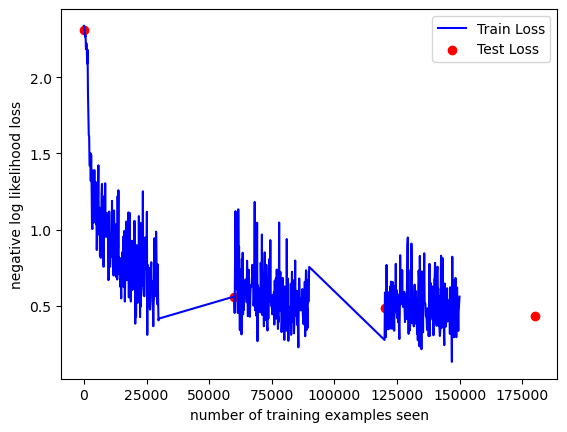

In [10]:
fig = plt.figure()
plt.plot(train_counter_all, train_losses_all, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig.show()

### Predict the Results

Currently, our accuracy is only 82%. This means that we need to train a more powerful network with more epochs. We predict that as we increase the number of convolution layers, we will get better performance.

#### Search Different Network Architectures with Ray Tune

Here we implement hyper-parameter tuning with Ray tune. Turns out it is a pain to run Ray Tune on Jupyter Notebook, we run it in a separate script `project4_part2.py`.